In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import basic visualization libraries 
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.style.use('fivethirtyeight')
import seaborn as sns 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dealing with Imbalanced Data
In this notebook, we will go through some of the basic techinques for dealing with imbalanced datasets. This is a companion workbook for the 365 Data Science course on ML Process. This notebook only foucses on implementation. Check out the course or the documentation for the in-depth explanations of each approach. 

We will cover:
- Random Oversampling
- Random Undersampling 
- Synthetic Minority Oversampling (SMOTE)
- Borderline SMOTE
- Adaptive Synthetic Oversampling 

imblearn Documentation: https://imbalanced-learn.org/stable/

### On the Data 
This dataset is a good representation of what you may see in the real world. Most data will have some imbalances, and in certain domains you will see a lot of inequality. You will likely see large imbalances in cases of expensive purchases or fraud detection.

In [14]:
#Read in Data 
df_train = pd.read_csv('aug_train.csv')

As you can see below, the data is imbalanced with far more 0's than 1's. While there isn't a massive imbalance, using different sampling methods could help improve our model results. 

In [15]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


<AxesSubplot: >

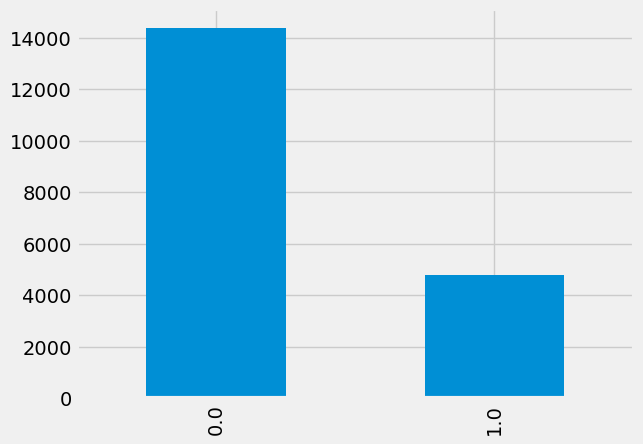

In [16]:
df_train.target.value_counts().plot.bar()

In [17]:
#create validation dataset to see how different sampling methocds could impact model outcomes
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df_train.drop(['enrollee_id','target'], axis =1))
y = df_train[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<AxesSubplot: xlabel='target'>

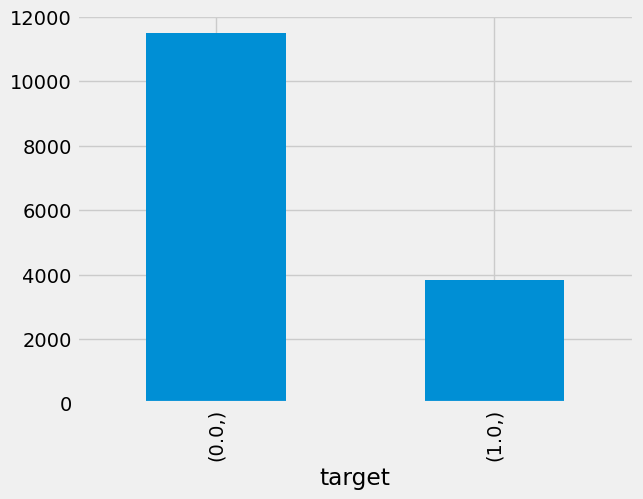

In [18]:
# see imblance in data majority is not looking for a job change (0)
y_train.value_counts().plot.bar()

In [19]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [20]:
# model to validate on 


## Parameters 

### For all sampling models

sampling_strategy: float, str, dict or callable, default=’auto’

>- float
    - When float, it corresponds to the desired ratio of the number of samples in the minority class over 
    the number of samples in the majority class after resampling. Therefore, the ratio is expressed as 
    \alpha_{os} = N_{rm} / N_{M} where N_{rm} is the number of samples in the minority class after 
    resampling and N_{M} is the number of samples in the majority class.
>- str
>    - `minority`: resample only the minority class;
>
>    - `not minority`: resample all classes but the minority class;
>
>    - `not majority`: resample all classes but the majority class;
>
>    - `all`: resample all classes;
>
>    - `auto`: equivalent to 'not majority'. 
>- `dict`
    - When dict, the keys correspond to the targeted classes. The values correspond to the desired number
    of samples for each targeted class.

`random_state`: int, RandomState instance, default=None 
- int --> Most cases use this to set a consistent random state

shrinkage: float or dict, default=None
- Shrinkage allows us to add slight noise to our data so that our resampled variables don't perfectly overlap. This could be useful for normalization of our results. A good example of how this works is located here: https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_shrinkage_effect.html
>- if **None**, a normal bootstrap will be generated without perturbation. It is equivalent to shrinkage=0 as well
>- if a **float** is given, the shrinkage factor will be used for all classes to generate the smoothed bootstrap;
>- if a **dict** is given, the shrinkage factor will specific for each class. The key correspond to the targeted class and the value is the shrinkage factor.

### For Smote and Borderline Smote
`k_neighbor`: sint or object, default=5
- If int, number of nearest neighbours to used to construct synthetic samples. If object, an estimator that inherits from KNeighborsMixin that will be used to find the k_neighbors.

`n_jobs`: int, default=None
- Number of CPU cores used during the cross-validation loop. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

### For Borderline Smote
kind: {“borderline-1”, “borderline-2”}, default=’borderline-1’
>- The type of SMOTE algorithm to use one of the following options: 'borderline-1', 'borderline-2'.
>- Breakdown of difference between borderline-1 and borderline-2: https://sci2s.ugr.es/keel/pdf/specific/congreso/han_borderline_smote.pdf

- `Copied from Docs`: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
- `Smote`: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- `Borderline Smote`: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html

# Random Oversampling
Random Oversampling is simply randomly picking data points in our minority class and duplicating them. 

In [21]:
# ! pip install imblearn

In [22]:
from imblearn.over_sampling import RandomOverSampler

o_smpl = RandomOverSampler(random_state = 42) 

X_o_smpl, y_o_smpl = o_smpl.fit_resample(X_train,y_train)


<AxesSubplot: xlabel='target'>

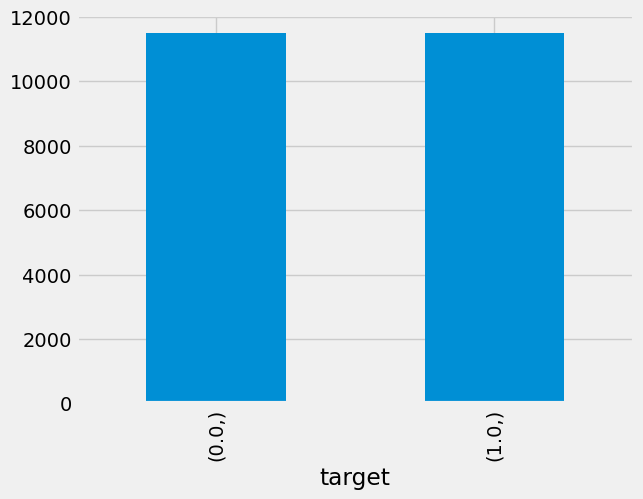

In [23]:
y_o_smpl.value_counts().plot.bar()

# Random Undersampling
Random Undersampling is simply randomly picking data points in our majority class and removing them. 

In [24]:
from imblearn.under_sampling import RandomUnderSampler

u_smpl = RandomUnderSampler(random_state = 42) 

X_u_smpl, y_u_smpl = u_smpl.fit_resample(X_train,y_train)


<AxesSubplot: xlabel='target'>

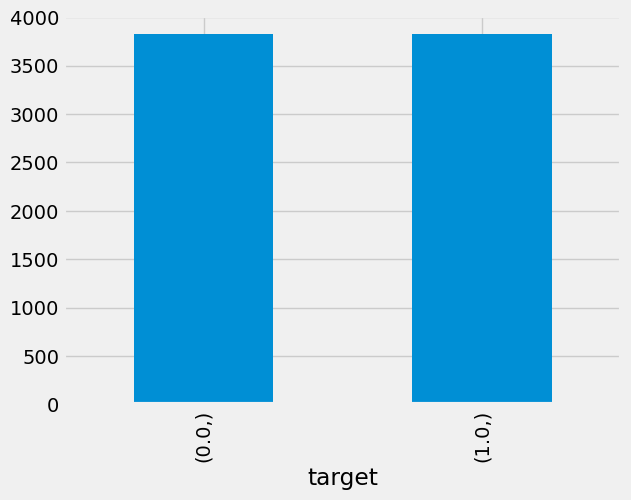

In [25]:
#note how many less total rows we have now 
y_u_smpl.value_counts().plot.bar()

# Synthetic Minority Oversampling (SMOTE)
Synthetic Minority Oversampling (SMOTE) is an oversampling technique that creates synthetic data points. SMOTE address’ the core problem in oversampling. Oversampling creates duplicate datapoints whereas SMOTE slightly alters these data points. 

In [26]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state = 42) 

X_smote, y_smote = smote.fit_resample(X_train,y_train)

<AxesSubplot: xlabel='target'>

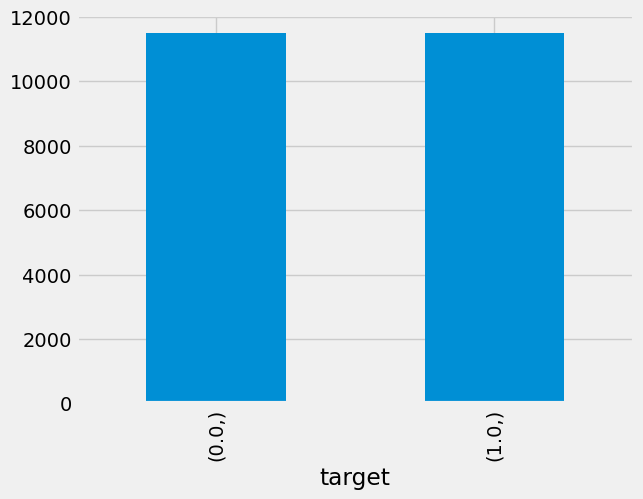

In [27]:
y_smote.value_counts().plot.bar()

# Borderline Smote
The idea behind borderline SMOTE is that we only want to use data that’s at risk of being misclassified as the data to be oversampled. In this case, we build a classifier to classify points as positive or negative. Then, for the data points we misclassify, we oversample those data points. This would hopefully train our algorithm to better recognize these difficult instances and correct for them. 

In [28]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(random_state = 42) 

X_bsmote, y_bsmote = bsmote.fit_resample(X_train,y_train)

<AxesSubplot: xlabel='target'>

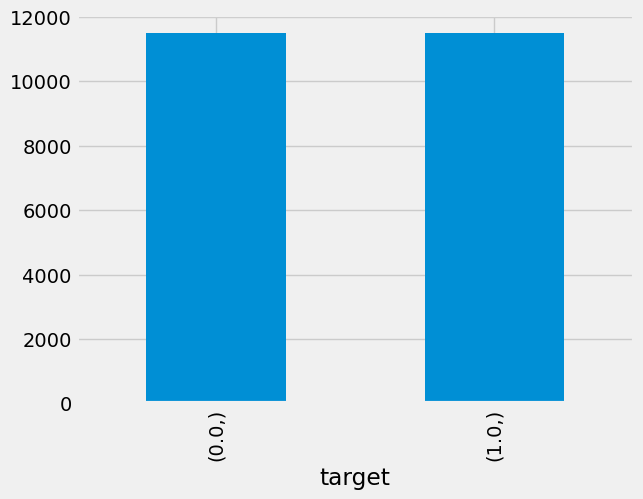

In [29]:
y_bsmote.value_counts().plot.bar()

# Adaptive Synthetic Oversampling (ADASYN)
The idea behind AdaSyn is to use a weight distribution of our minority class. Essentially, we give higher weight to instances that are more difficult to learn and lower weight to instances that are easier to learn. AdaSyn is very similar to safe-level SMOTE, except there’s just a different way of computing the synthetic data points. 

In [30]:
from imblearn.over_sampling import ADASYN 
adasyn = ADASYN(random_state = 42) 

X_ada, y_ada = adasyn.fit_resample(X_train,y_train)

In [39]:
X_ada

,city_development_index,training_hours,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.910000,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.897000,262,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0.910000,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.910000,35,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.555000,43,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23085,0.920000,25,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
23086,0.920000,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23087,0.916571,57,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23088,0.902097,57,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: xlabel='target'>

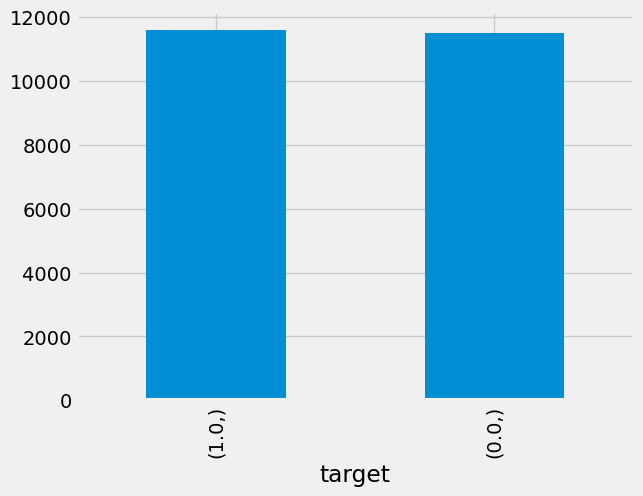

In [31]:
y_ada.value_counts().plot.bar()

# How do these compare?
Let's quickly compare our sampling techniques by looking at the differences in the sampling data. Then let's compare the results of after feeding them into a model. This is just a little experiment, but it can show how much of a difference sampling can make depending on your data and models. 

Let's train a simple random forest on each of the different types of samples, then let's see the difference in validation accuracy. 

In [32]:
#let's explore a few variables across these 4 different 
# oversampling techniques across two variables 'city_development_index' and 'training_hours'

print('city_development_index Differences:')
for i in [X_o_smpl, X_smote, X_bsmote, X_ada]:
    print(i.mean()['city_development_index'])

print('training_hours Differences:')
for i in [X_o_smpl, X_smote, X_bsmote, X_ada]:
    print(i.mean()['training_hours'])
    
#what is important here is that there are differences in the sampling 
#of each techinque, not where the differences come in these two variables 

city_development_index Differences:
0.8050509955656031
0.8043782346947118
0.8069758745351676
0.8079763319501342
training_hours Differences:
64.42535431701592
64.32210242587601
65.87618467959308
65.87271546123863


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#oversampling model 
clf_os = RandomForestClassifier(random_state=0)
clf_os.fit(X_o_smpl, y_o_smpl)
os_pred = clf_os.predict(X_test)

#undersampling model 
clf_us = RandomForestClassifier(random_state=0)
clf_us.fit(X_u_smpl, y_u_smpl)
us_pred = clf_us.predict(X_test)

#SMOTE 
clf_sm = RandomForestClassifier(random_state=0)
clf_sm.fit(X_smote, y_smote)
sm_pred = clf_sm.predict(X_test)

#borderline SMOTE 
clf_bsm = RandomForestClassifier(random_state=0)
clf_bsm.fit(X_bsmote, y_bsmote)
bsm_pred = clf_bsm.predict(X_test)

#ADDASYN
clf_ada = RandomForestClassifier(random_state=0)
clf_ada.fit(X_ada, y_ada)
ada_pred = clf_ada.predict(X_test)

print('Oversampling Score: %.3f' % accuracy_score(y_test,os_pred))
print('Undersampling Score: %.3f' % accuracy_score(y_test,us_pred))
print('SMOTE Score: %.3f '% accuracy_score(y_test,sm_pred))
print('Borderline SMOTE Score: %.3f'% accuracy_score(y_test,bsm_pred))
print('ADASYN Score: %.3f'% accuracy_score(y_test,ada_pred))

/var/folders/pr/k1cjyyh56sv6wyyxm023snx00000gn/T/ipykernel_4514/2198834000.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_os.fit(X_o_smpl, y_o_smpl)
/var/folders/pr/k1cjyyh56sv6wyyxm023snx00000gn/T/ipykernel_4514/2198834000.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_us.fit(X_u_smpl, y_u_smpl)
/var/folders/pr/k1cjyyh56sv6wyyxm023snx00000gn/T/ipykernel_4514/2198834000.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_sm.fit(X_smote, y_smote)
/var/folders/pr/k1cjyyh56sv6wyyxm023snx00000gn/T/ipykernel_4514/2198834000.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Oversampling Score: 0.782
Undersampling Score: 0.754
SMOTE Score: 0.775 
Borderline SMOTE Score: 0.773
ADASYN Score: 0.772


In [34]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
pred = clf_ada.predict(X_test)
print('No Change Score: %.3f'% accuracy_score(y_test,pred))

/var/folders/pr/k1cjyyh56sv6wyyxm023snx00000gn/T/ipykernel_4514/3596811913.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


No Change Score: 0.772


In [35]:
#now let's tune some features in SMOTE to see if we get slightly better results.
# Let's do this with SMOTE

In [36]:
for i in range(1,10,1):
    smote = SMOTE(k_neighbors = i, random_state=42) 

    X_smote, y_smote = smote.fit_resample(X_train,y_train)

    clf_sm = RandomForestClassifier(random_state=0)
    clf_sm.fit(X_smote, y_smote.values.ravel())
    sm_pred = clf_sm.predict(X_test)
    print('K = ' +str(i))
    print('SMOTE Score: %.3f '% accuracy_score(y_test,sm_pred))
    
#it seems like k = 1 produced the best results. 

K = 1
SMOTE Score: 0.777 
K = 2
SMOTE Score: 0.776 
K = 3
SMOTE Score: 0.773 
K = 4
SMOTE Score: 0.774 
K = 5
SMOTE Score: 0.775 
K = 6
SMOTE Score: 0.775 
K = 7
SMOTE Score: 0.770 
K = 8
SMOTE Score: 0.775 
K = 9
SMOTE Score: 0.775 
